In [50]:
import argparse
import multiprocessing as mp
import os
import random as rn
import warnings
from pathlib import Path
from shlex import split
from subprocess import Popen, PIPE, STDOUT, run
from tempfile import mkstemp

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import Normalizer
import timesynth as ts

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    rn.seed(seed)
    np.random.seed(seed)

Index(['timeStamp', 'demand', 'precip', 'temp'], dtype='object')
(1000, 4) 0
(1000, 2) 0


,timeStamp,demand
0,2012-01-01 00:00:00,4937.5
1,2012-01-01 01:00:00,4752.1
2,2012-01-01 02:00:00,4542.6
3,2012-01-01 03:00:00,4357.7
4,2012-01-01 04:00:00,4275.5
...,...,...
995,2012-02-11 11:00:00,5841.7
996,2012-02-11 12:00:00,5882.4
997,2012-02-11 13:00:00,5888.5
998,2012-02-11 14:00:00,5873.8


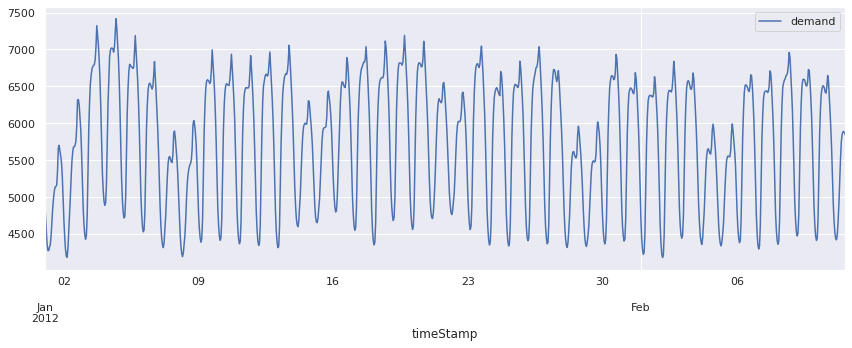

In [51]:
data_path = "data/nyc_energy.csv"
data = pd.read_csv(data_path)[:-81][:1000]
dt, target = "timeStamp", "demand"
print(data.columns)
print(data.shape, data[target].isna().sum())

data[dt] = pd.to_datetime(data[dt])
data = data.set_index(dt)
data = data[[target]]
data = data.resample("h").mean().interpolate()
data = data.reset_index()

print(data.shape, data[target].isna().sum())
display(data)
data.plot(x=dt, y=target, figsize=(12, 5))
plt.tight_layout()
plt.show()

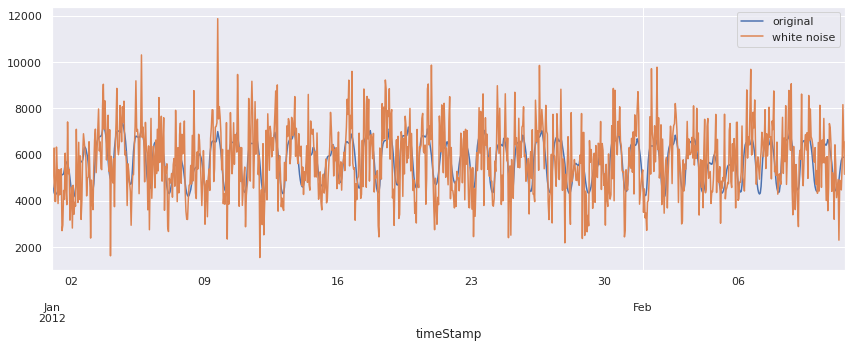

In [82]:
reset_seed()

target_std = data[target].std()
white_noise = ts.noise.GaussianNoise(std=1.5*target_std).sample_vectorized(data.index)

df = pd.DataFrame({dt: data[dt], "original": data[target],
                   "white noise": data[target]+white_noise})
df.plot(x=dt, figsize=(12, 5))
plt.tight_layout()
plt.show()

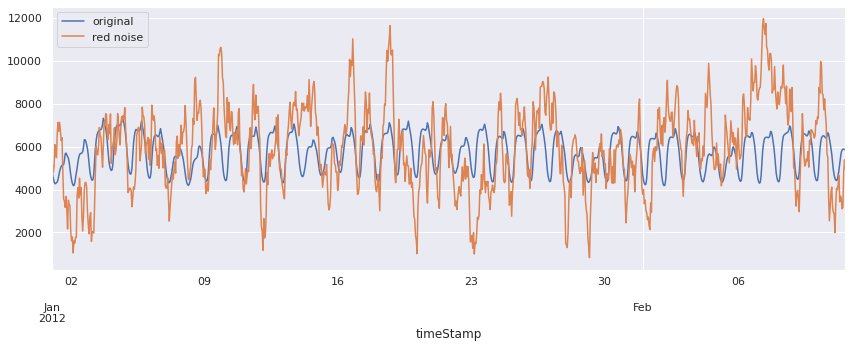

In [81]:
reset_seed()

target_std = data[target].std()
dummy_signal = ts.signals.Sinusoidal(frequency=0)
noise_generator = ts.noise.RedNoise(std=target_std, tau=10)
timeseries = ts.TimeSeries(dummy_signal, noise_generator=noise_generator)
red_noise = timeseries.sample(data.index)[0]

# df = pd.DataFrame({dt: data[dt], "red noise": red_noise})
df = pd.DataFrame({dt: data[dt], "original": data[target],
                   "red noise": data[target]+red_noise})
df.plot(x=dt, figsize=(12, 5))
plt.tight_layout()
plt.show()